# **Project 4: Plant leave recognizer**


Using the «Plants» dataset of Project 1, the task is to implement a deep-learning-based system classifying pictures of leaves according to the twelve types of plants.


### Import Data

Import JSON file for credentials.

In [1]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 5.5 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
import os
import re
import shutil
from google.colab import files
import json
import getpass
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score
import zipfile
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import random
from PIL import Image
import cv2
import keras_tuner as kt
from tensorflow.keras.callbacks import ModelCheckpoint
from kerastuner.tuners import RandomSearch
import pickle

<ipython-input-2-4627757935ad>:25: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [4]:
use_upload = input('Upload? (y/n): ')
if use_upload.lower() == 'y':
    uploaded = files.upload()

    for name in uploaded.keys():
        if 'kaggle' in name.lower():
            os.rename(name, 'KaggleCredential.json')
            break
else:
    username = input('Enter your Kaggle username: ')
    password = getpass.getpass('Enter your Kaggle key: ')

    credentials = {'username': username, 'key': password}
    with open('KaggleCredential.json', 'w') as f:
        json.dump(credentials, f)

with open('KaggleCredential.json', 'r') as f:
    credentials = json.load(f)

username = credentials['username']
password = credentials['key']

Upload? (y/n): y


Saving kaggle.json to kaggle.json


  Read JSON Credentials

In [5]:
credentials = {'username': username, 'key': password}
kaggle_dir = '/root/.kaggle'
if not os.path.exists(kaggle_dir):
    os.makedirs(kaggle_dir)
with open(os.path.join(kaggle_dir, 'kaggle.json'), 'w') as f:
    json.dump(credentials, f)

!chmod 600 /root/.kaggle/kaggle.json

In [6]:
# use this command in case you want to delete a folder.
#!rm -rf data

In [7]:
dir = "/content/data/" # Set Directory
train_dir = '/content/data/Plants_2/train'
val_dir = '/content/data/Plants_2/valid'
test_dir = '/content/data/Plants_2/test'

In [8]:
%%time

import kaggle

# Authenticate Kaggle API
kaggle.api.authenticate()

# Download the dataset
dataset = 'csafrit2/plant-leaves-for-image-classification'
kaggle.api.dataset_download_files(dataset)

# Extract the zip file to the current working directory (i.e., the root directory in Colab)
with zipfile.ZipFile('plant-leaves-for-image-classification.zip', 'r') as zip_ref:
    zip_ref.extractall(dir)  # Extract to the current directory (e.g., '/content/')

CPU times: user 1min 24s, sys: 36.3 s, total: 2min 1s
Wall time: 3min 17s


# Pre Processing

In [12]:
# Leaves Classes

leaves = [
    "Mango",
    "Arjun",
    "Alstonia Scholaris",
    "Gauva",
    "Jamun",
    "Jatropha",
    "Pongamia Pinnata",
    "Basil",
    "Pomegranate",
    "Lemon",
    "Chinar"
]

## Train - Pre Processing

In [25]:
# First Phase: Create new folders for each leaf class, then move all the folders which name match the one in the folder.

for name in leaves:
    # Create a new folders. Each has names in the list leaves
    new_folder_path = os.path.join(train_dir, name)
    os.makedirs(new_folder_path, exist_ok=True)

    # Iterate over each folder in the directory, so to get the folder path
    for folder_name in os.listdir(train_dir):
        folder_path = os.path.join(train_dir, folder_name)

        # Check if folder_name matches any of the current name using regex
        if re.search(name, folder_name, re.IGNORECASE):
            # If so, move the folder to the new folder path
            shutil.move(folder_path, new_folder_path)

# Second Phase

folder_paths = []

# Iterate over each item (files and folders) in the directory
for item_name in os.listdir(train_dir):
    item_path = os.path.join(train_dir, item_name) # Class-Leaf folders

    # Check if the item is a folder
    if os.path.isdir(item_path):
        # Append the folder path to the list
        folder_paths.append(item_path)

# Third Phase

for i in folder_paths:
  for item_name in os.listdir(i):
      item_path = os.path.join(i, item_name)

      # Check if the item is a folder
      if os.path.isdir(item_path):
          # Iterate over each file in the inner folder
          for file_name in os.listdir(item_path):
              file_path = os.path.join(item_path, file_name)

              # Move the file to the outer folder
              shutil.move(file_path, i)

          # Delete the inner folder
          shutil.rmtree(item_path)

In [26]:
current_path = "/content/data/Plants_2/train/Bael diseased (P4b)"
new_path = "/content/data/Plants_2/train/Bael"
shutil.move(current_path, new_path)

'/content/data/Plants_2/train/Bael'

Delete errors

In [27]:
#shutil.rmtree("/content/data/Plants_2/train/Alstonia Scholaris")
#shutil.rmtree("/content/data/Plants_2/train/Pongamia Pinnata")

## Validation - Pre Processing

In [28]:
for name in leaves:
    # Create a new folder for each name
    new_folder_path = os.path.join(val_dir, name)
    os.makedirs(new_folder_path, exist_ok=True)

    # Iterate over each folder in the directory
    for folder_name in os.listdir(val_dir):
        folder_path = os.path.join(val_dir, folder_name)

        # Check if folder_name matches the current name using regex
        if re.search(name, folder_name, re.IGNORECASE):
            # Move the folder to the new folder path
            shutil.move(folder_path, new_folder_path)

folder_paths = []

# Iterate over each item (files and folders) in the directory
for item_name in os.listdir(val_dir):
    item_path = os.path.join(val_dir, item_name)

    # Check if the item is a folder
    if os.path.isdir(item_path):
        # Append the folder path to the list
        folder_paths.append(item_path)

for i in folder_paths:
  for item_name in os.listdir(i):
      item_path = os.path.join(i, item_name)

      # Check if the item is a folder
      if os.path.isdir(item_path):
          # Iterate over each file in the inner folder
          for file_name in os.listdir(item_path):
              file_path = os.path.join(item_path, file_name)

              # Move the file to the outer folder
              shutil.move(file_path, i)

          # Delete the inner folder
          shutil.rmtree(item_path)

In [29]:
current_path = "/content/data/Plants_2/valid/Bael diseased (P4b)"
new_path = "/content/data/Plants_2/valid/Bael"
shutil.move(current_path, new_path)

'/content/data/Plants_2/valid/Bael'

## Test - Pre Processing

In [30]:
for name in leaves:
    # Create a new folder for each name
    new_folder_path = os.path.join(test_dir, name)
    os.makedirs(new_folder_path, exist_ok=True)

    # Iterate over each folder in the directory
    for folder_name in os.listdir(test_dir):
        folder_path = os.path.join(test_dir, folder_name)

        # Check if folder_name matches the current name using regex
        if re.search(name, folder_name, re.IGNORECASE):
            # Move the folder to the new folder path
            shutil.move(folder_path, new_folder_path)

folder_paths = []

# Iterate over each item (files and folders) in the directory
for item_name in os.listdir(test_dir):
    item_path = os.path.join(test_dir, item_name)

    # Check if the item is a folder
    if os.path.isdir(item_path):
        # Append the folder path to the list
        folder_paths.append(item_path)


for i in folder_paths:
  for item_name in os.listdir(i):
      item_path = os.path.join(i, item_name)

      # Check if the item is a folder
      if os.path.isdir(item_path):
          # Iterate over each file in the inner folder
          for file_name in os.listdir(item_path):
              file_path = os.path.join(item_path, file_name)

              # Move the file to the outer folder
              shutil.move(file_path, i)

          # Delete the inner folder
          shutil.rmtree(item_path)

In [31]:
current_path = "/content/data/Plants_2/test/Bael diseased (P4b)"
new_path = "/content/data/Plants_2/test/Bael"
shutil.move(current_path, new_path)

'/content/data/Plants_2/test/Bael'

## Parameters

In [32]:
HEIGHT = 64
WIDTH = 64
BATCH = 64
EPOCHS = 10

In [33]:
train_data = tf.keras.utils.image_dataset_from_directory(
                                  train_dir,
                                  image_size=(HEIGHT,WIDTH),
                                  interpolation="mitchellcubic",
                                  crop_to_aspect_ratio=True,
                                  seed=505,
                                  shuffle=True,
                                  batch_size=BATCH
                                  )

val_data = tf.keras.utils.image_dataset_from_directory(
                                  val_dir,
                                  image_size=(HEIGHT,WIDTH),
                                  interpolation="mitchellcubic",
                                  crop_to_aspect_ratio=True,
                                  seed=505,
                                  shuffle=True,
                                  batch_size=BATCH
                                  )

test_data = tf.keras.utils.image_dataset_from_directory(
                                  test_dir,
                                  image_size=(HEIGHT,WIDTH),
                                  interpolation="mitchellcubic",
                                  crop_to_aspect_ratio=True,
                                  seed=505,
                                  shuffle=True,
                                  batch_size=BATCH
                                  )

Found 4274 files belonging to 12 classes.
Found 110 files belonging to 12 classes.
Found 110 files belonging to 12 classes.


In [34]:
NUM_CLASSES = len(train_data.class_names)

# Exploratory Data Analysis

Display the first image in the batch

In [ ]:
for batch_images, batch_labels in train_data:

    print("Batch Images Shape:", batch_images.shape)
    print("Batch Labels Shape:", batch_labels.shape)

    first_image = batch_images[0].numpy().astype("uint8")
    plt.imshow(first_image)
    plt.axis("off")
    plt.show()

`train_data`, `val_data` and `test_data` are our data. Make sure that each data has the same class (ie. the same folder names)

In [ ]:
print(train_data.class_names, val_data.class_names, test_data.class_names)

['Alstonia Scholaris', 'Arjun', 'Bael', 'Basil', 'Chinar', 'Gauva', 'Jamun', 'Jatropha', 'Lemon', 'Mango', 'Pomegranate', 'Pongamia Pinnata'] ['Alstonia Scholaris', 'Arjun', 'Bael', 'Basil', 'Chinar', 'Gauva', 'Jamun', 'Jatropha', 'Lemon', 'Mango', 'Pomegranate', 'Pongamia Pinnata'] ['Alstonia Scholaris', 'Arjun', 'Bael', 'Basil', 'Chinar', 'Gauva', 'Jamun', 'Jatropha', 'Lemon', 'Mango', 'Pomegranate', 'Pongamia Pinnata']


`train_count` allows us to keep track of the cardinality of each class.

In [ ]:
train_count = {}

# Iterate over the folders in the directory
for folder_name in os.listdir(train_dir):
    folder_path = os.path.join(train_dir, folder_name)

    # Check if the item in the directory is a folder
    if os.path.isdir(folder_path):
        file_count = len(os.listdir(folder_path))
        train_count[folder_name] = file_count

print(train_count)

{'Gauva': 398, 'Jamun': 603, 'Arjun': 432, 'Jatropha': 237, 'Mango': 414, 'Alstonia Scholaris': 412, 'Lemon': 216, 'Pomegranate': 538, 'Bael': 107, 'Pongamia Pinnata': 577, 'Chinar': 203, 'Basil': 137}


A plot of each class' cardinality.

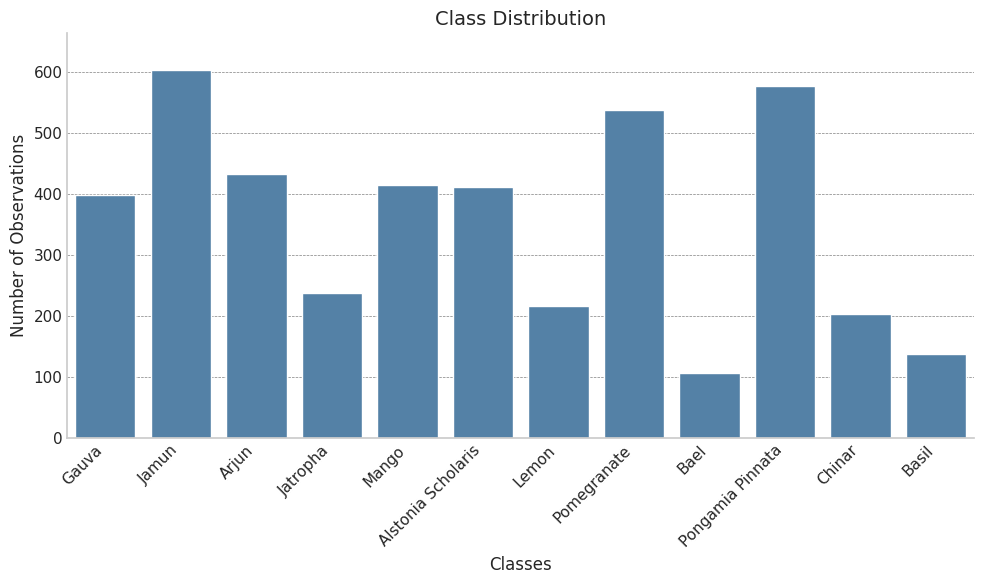

In [ ]:
keys = list(train_count.keys())
values = list(train_count.values())

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x=keys, y=values, color="steelblue")

plt.xlabel("Classes", fontsize=12)
plt.ylabel("Number of Observations", fontsize=12)
plt.title("Class Distribution", fontsize=14)

plt.xticks(rotation=45, ha="right")

plt.grid(True, axis="y", linestyle="--", linewidth=0.5, color="gray")

plt.ylim(0, max(values) * 1.1)  # Set the y-axis limit to 10% above the maximum value

plt.tick_params(axis="both", which="both", length=0)  # Remove tick marks
sns.despine()

plt.tight_layout()
plt.show()

`leaves_weights` help us to keep track of each class' weight, which has been computed in the following way.

In [45]:
class_counts = {
    'Mango': 414,
    'Arjun': 432,
    'Alstonia Scholaris': 412,
    'Basil': 137,
    'Pongamia Pinnata': 577,
    'Chinar': 203,
    'Gauva': 398,
    'Jamun': 603,
    'Lemon': 216,
    'Pomegranate': 538,
    'Jatropha': 237,
    'Bael': 107
}

# Extract the class labels and counts from the dictionary
class_labels = list(class_counts.keys())
class_sample_counts = list(class_counts.values())

# Assign numeric values to the class labels
class_label_to_number = {class_label: i for i, class_label in enumerate(class_labels)}
class_numbers = np.array([class_label_to_number[label] for label in class_labels]) # array with class numbers

# Compute class weights using the 'balanced' strategy
class_weights = np.max(class_sample_counts) / class_sample_counts

# Create a dictionary to store the class weights
class_weight_dict = {class_label_to_number[label]: weight for label, weight in zip(class_labels, class_weights)} # class_numbers : weights
leaves_weights = {class_label: weight for class_label, weight in zip(class_labels, class_weights)} # class_number : weights

print(leaves_weights)
print(class_weight_dict)

{'Mango': 1.4565217391304348, 'Arjun': 1.3958333333333333, 'Alstonia Scholaris': 1.4635922330097086, 'Basil': 4.401459854014599, 'Pongamia Pinnata': 1.0450606585788562, 'Chinar': 2.9704433497536944, 'Gauva': 1.515075376884422, 'Jamun': 1.0, 'Lemon': 2.7916666666666665, 'Pomegranate': 1.120817843866171, 'Jatropha': 2.5443037974683542, 'Bael': 5.635514018691588}
{0: 1.4565217391304348, 1: 1.3958333333333333, 2: 1.4635922330097086, 3: 4.401459854014599, 4: 1.0450606585788562, 5: 2.9704433497536944, 6: 1.515075376884422, 7: 1.0, 8: 2.7916666666666665, 9: 1.120817843866171, 10: 2.5443037974683542, 11: 5.635514018691588}


A plot of the weights. As we can see, the classes with the highest value of weights are the ones with the lowest cardinality.

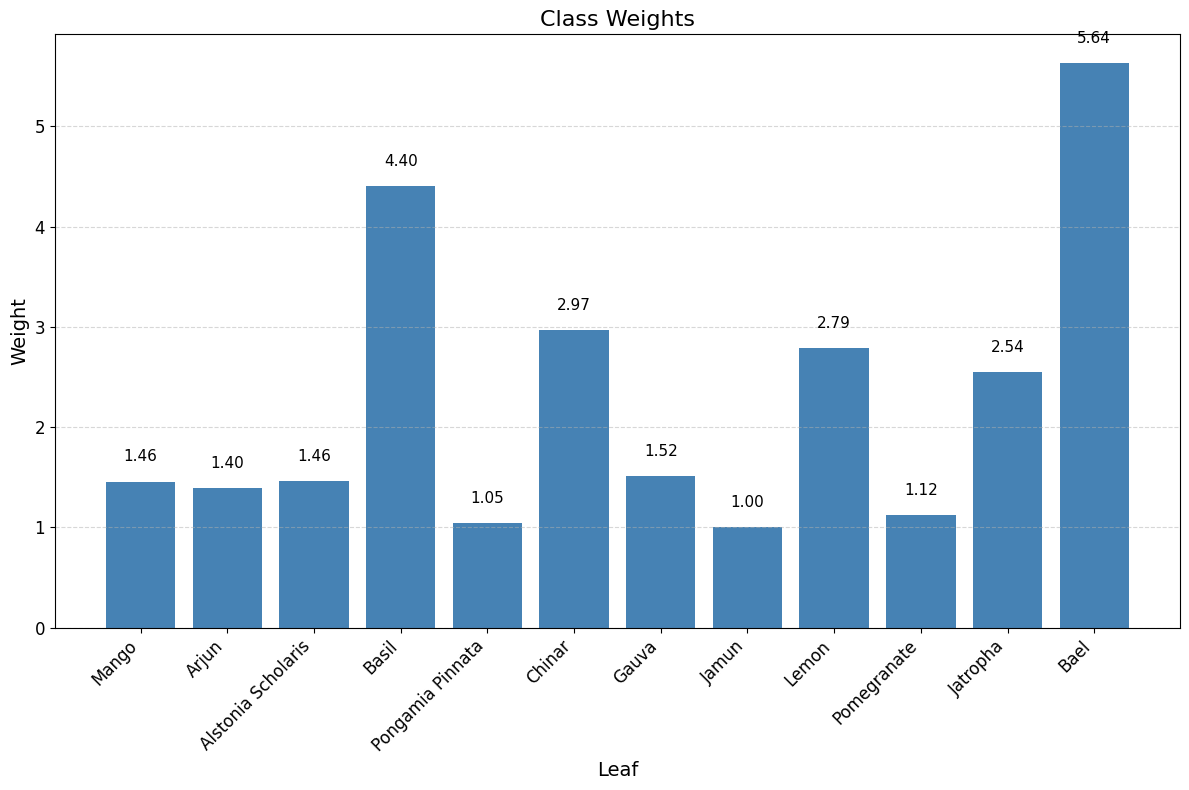

In [46]:
leaf_names = list(leaves_weights.keys())
weights = list(leaves_weights.values())

plt.figure(figsize=(12, 8))
plt.bar(leaf_names, weights, color='steelblue')
plt.xlabel('Leaf', fontsize=14)
plt.ylabel('Weight', fontsize=14)
plt.title('Class Weights', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Add data labels above each bar
for i, v in enumerate(weights):
    plt.text(i, v + 0.2, f'{v:.2f}', ha='center', fontsize=11)

plt.tight_layout()

plt.savefig('fra.png', dpi=300)
plt.show()

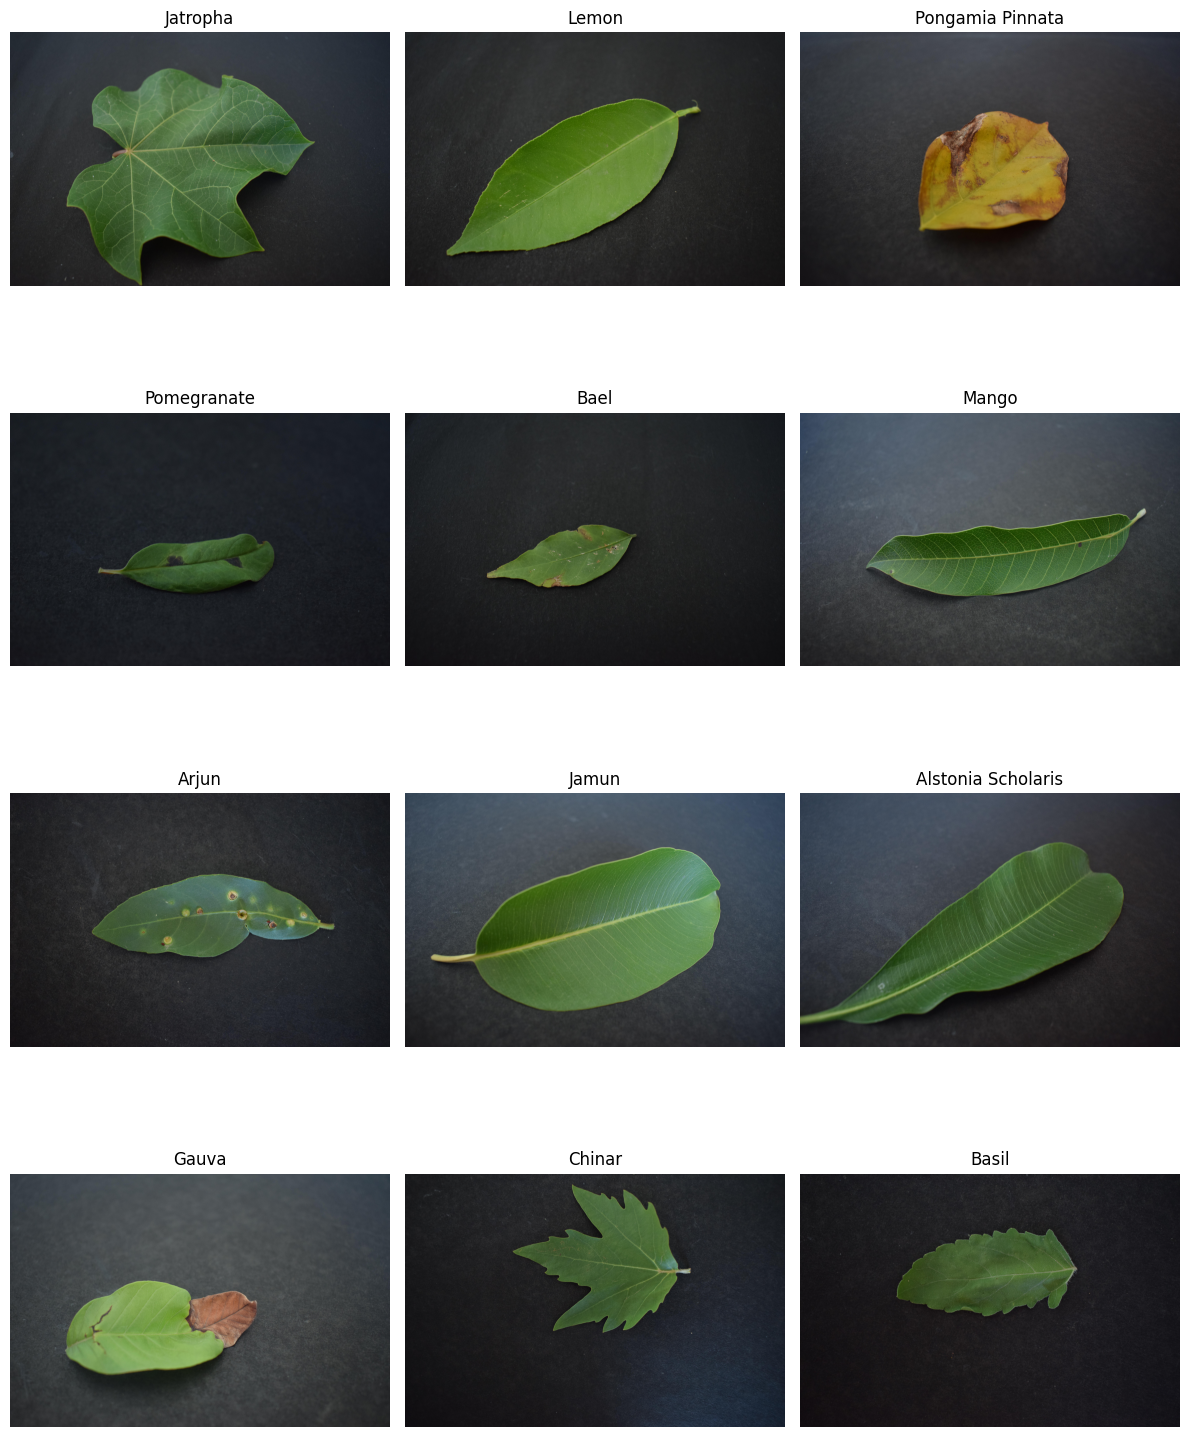

In [48]:
class_dirs = [os.path.join(train_dir, class_name) for class_name in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, class_name))]

# Shuffle the class directories
random.shuffle(class_dirs)

# Create a 4x3 grid for displaying the images
fig, axs = plt.subplots(4, 3, figsize=(12, 16))
axs = axs.flatten()

# Iterate through the class directories and display one image from each directory
for i, class_dir in enumerate(class_dirs):
    image_files = os.listdir(class_dir)
    if image_files:
        # Randomly select one image from the class directory
        image_file = random.choice(image_files)
        image_path = os.path.join(class_dir, image_file)
        image = mpimg.imread(image_path)

        # Display the image in the corresponding subplot
        ax = axs[i]
        ax.imshow(image)
        ax.set_title(os.path.basename(class_dir))
        ax.axis("off")

        # Break the loop if we have displayed the desired number of images
        if i == 11:
            break

# Adjust the spacing between subplots
plt.tight_layout()

# Show the grid of images
plt.savefig("/content/output.png")
plt.show()

Same as before, but this time the function outputs the resized version of a random image taken from each class, still belonging to the training set.

# Model Selection

Define `early_stopping`, it will be needed for training purposes.

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

In [ ]:
def simple():

    model = tf.keras.Sequential([
        layers.Conv2D(16, kernel_size=(3, 3), activation='sigmoid', input_shape=(HEIGHT, WIDTH, 3)),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(32, kernel_size=(3, 3), activation='sigmoid'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

simple_model = simple()
simple_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense (Dense)               (None, 128)               8

In [ ]:
def deep():

    model = tf.keras.Sequential([
        layers.Rescaling(1./255, input_shape=(HEIGHT, WIDTH, 3)),
        layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

    return model

deep_model = deep()
deep_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 64, 64, 3)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 12, 12, 128)      

In [ ]:
def deep_hpt(hp):

  model = tf.keras.Sequential([
    layers.Rescaling(1./255, input_shape=(HEIGHT, WIDTH, 3)),
    layers.Conv2D(hp.Int('conv1_filters', min_value=32, max_value=32, step=32), kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(hp.Int('conv2_filters', min_value=32, max_value=64, step=32), kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(hp.Int('conv3_filters', min_value=64, max_value=128, step=32), kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(hp.Int('dense_units', min_value=128, max_value=256, step=128), activation='relu'),
    layers.Dense(NUM_CLASSES, activation='softmax')
    ])

  model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

  return model

## Training

###  Simple Model

In [ ]:
simple_history = simple_model.fit(train_data, validation_data = val_data, epochs = EPOCHS, callbacks = [early_stopping]) # not using class weight

`simple` model has also been stored locally.

In [ ]:
simple_model = keras.models.load_model('/plant_classification/simple model/simple.h5')

In [ ]:
with open('/plant_classification/simple model/simple_history.pkl', 'rb') as file:
    simple_history = pickle.load(file)

In [ ]:
train_loss, train_accuracy = simple_model.evaluate(train_data)

print("Train Loss:", train_loss)
print("Train Accuracy:", train_accuracy)

67/67 [==============================] - 599s 8s/step - loss: 1.4140 - accuracy: 0.4995
Test Loss: 1.4140039682388306
Test Accuracy: 0.4995320439338684


In [ ]:
train_loss, train_accuracy = simple_model.evaluate(val_data)

print("Validation Loss:", train_loss)
print("Validation Accuracy:", train_accuracy)

2/2 [==============================] - 18s 40ms/step - loss: 1.5950 - accuracy: 0.3909
Train Loss: 1.5950233936309814
Train Accuracy: 0.3909091055393219


In [ ]:
test_loss, test_accuracy = simple_model.evaluate(test_data)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

3/3 [==============================] - 16s 6ms/step - loss: 1.4261 - accuracy: 0.3545
Test Loss: 1.4261085987091064
Test Accuracy: 0.3545454442501068


Visualizing `simple_history`

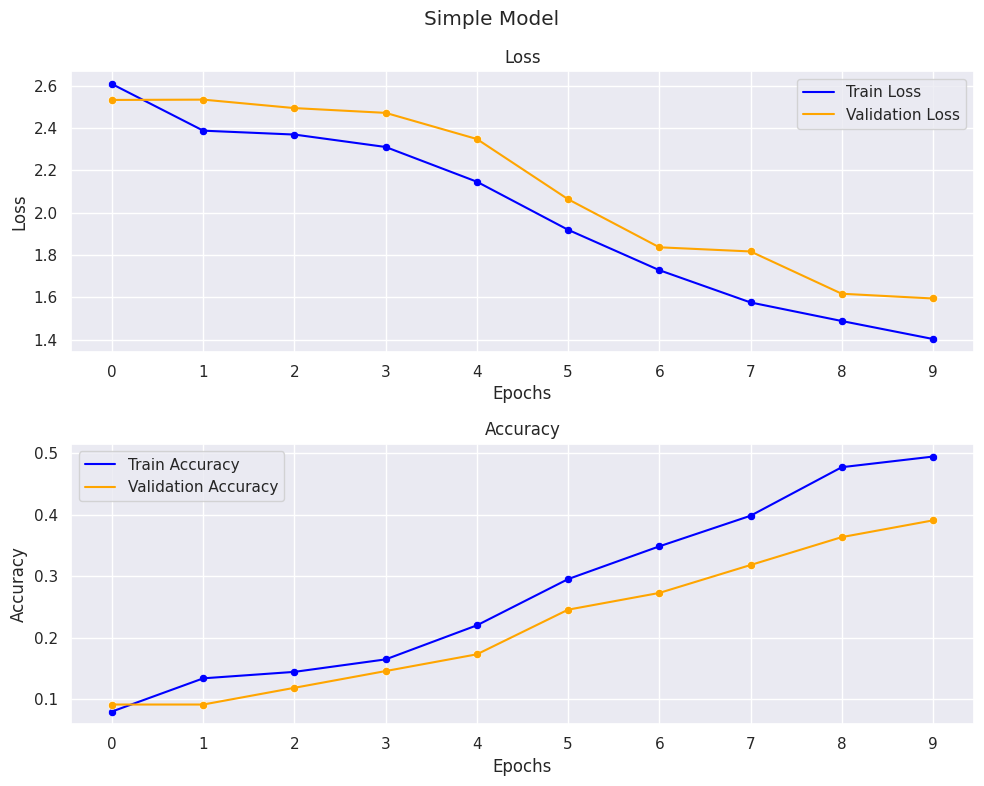

In [ ]:
sns.set(style='darkgrid')
fig, axes = plt.subplots(nrows=2, figsize=(10, 8))

sns.lineplot(x=range(len(simple_model["loss"])), y=simple_model["loss"], color='blue', label='Train Loss', ax=axes[0])
sns.lineplot(x=range(len(simple_model["val_loss"])), y=simple_model["val_loss"], color='orange', label='Validation Loss', ax=axes[0])
sns.scatterplot(x=range(len(simple_model["loss"])), y=simple_model["loss"], color='blue', ax=axes[0])
sns.scatterplot(x=range(len(simple_model["val_loss"])), y=simple_model["val_loss"], color='orange', ax=axes[0])
axes[0].set_title('Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].xaxis.set_major_locator(plt.MaxNLocator(10))

sns.lineplot(x=range(len(simple_model["accuracy"])), y=simple_model["accuracy"], color='blue', label='Train Accuracy', ax=axes[1])
sns.lineplot(x=range(len(simple_model["val_accuracy"])), y=simple_model["val_accuracy"], color='orange', label='Validation Accuracy', ax=axes[1])
sns.scatterplot(x=range(len(simple_model["accuracy"])), y=simple_model["accuracy"], color='blue', ax=axes[1])
sns.scatterplot(x=range(len(simple_model["val_accuracy"])), y=simple_model["val_accuracy"], color='orange', ax=axes[1])

axes[1].set_title('Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].xaxis.set_major_locator(plt.MaxNLocator(10))

fig.suptitle('Simple Model')
fig.tight_layout()
fig.savefig('simple_model_plot.png', dpi=300)
plt.show()

### Deep Model



In [ ]:
%%time

deep_history = deep_model.fit(train_data,
                           validation_data = val_data,
                           epochs = EPOCHS,
                            callbacks = [early_stopping],
                           class_weight=class_weight_dict)

Epoch 1/10


In [ ]:
deep_model = keras.models.load_model('/plant_classification/deep model/deep.h5')

with open('/plant_classification/deep model/deep_history.pkl', 'rb') as file:
    deep_history = pickle.load(file)

In [ ]:
test_loss, test_accuracy = deep_model.evaluate(test_data)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

2/2 [==============================] - 17s 11ms/step - loss: 0.4732 - accuracy: 0.8727
Test Loss: 0.47322937846183777
Test Accuracy: 0.8727272748947144


In [ ]:
train_loss, train_accuracy = deep_model.evaluate(train_data)

print("Train Loss:", train_loss)
print("Train Accuracy:", train_accuracy)

67/67 [==============================] - 609s 8s/step - loss: 0.2070 - accuracy: 0.9338
Train Loss: 0.20702239871025085
Train Accuracy: 0.9337856769561768


In [ ]:
train_loss, train_accuracy = deep_model.evaluate(val_data)

print("Val Loss:", train_loss)
print("Val Accuracy:", train_accuracy)

2/2 [==============================] - 16s 10ms/step - loss: 0.7891 - accuracy: 0.8182
Val Loss: 0.7890708446502686
Val Accuracy: 0.8181818127632141


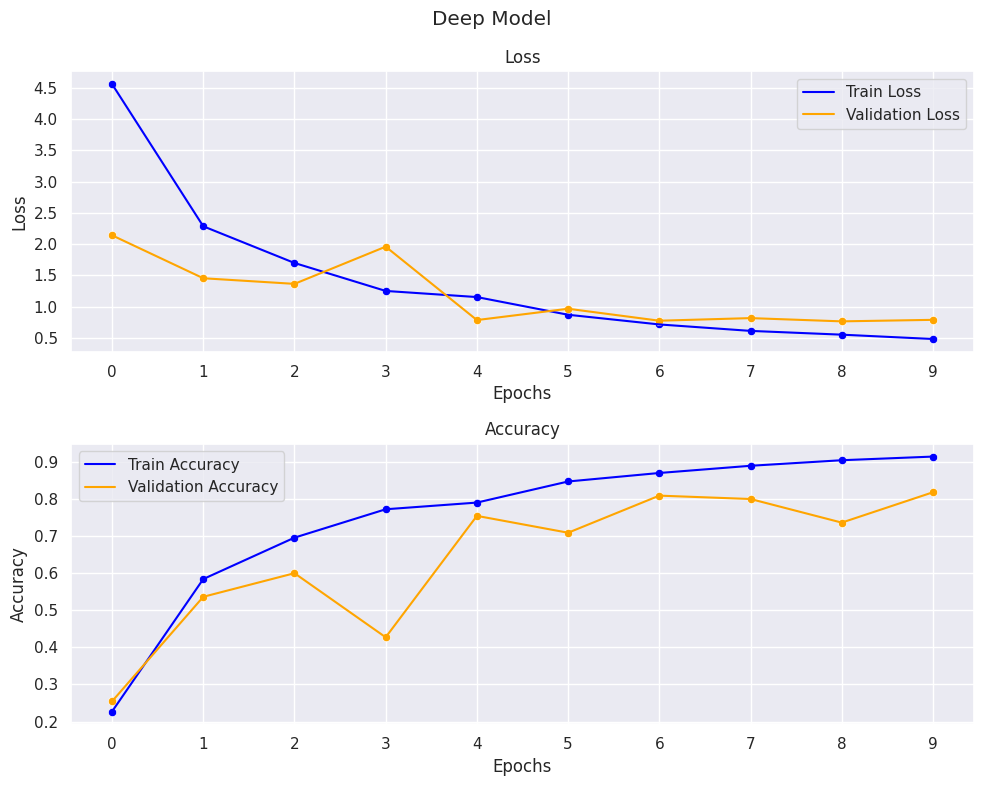

In [ ]:
sns.set(style='darkgrid')

fig, axes = plt.subplots(nrows=2, figsize=(10, 8))
sns.lineplot(x=range(len(deep_history["loss"])), y=deep_history["loss"], color='blue', label='Train Loss', ax=axes[0])
sns.lineplot(x=range(len(deep_history["val_loss"])), y=deep_history["val_loss"], color='orange', label='Validation Loss', ax=axes[0])
sns.scatterplot(x=range(len(deep_history["loss"])), y=deep_history["loss"], color='blue', ax=axes[0])
sns.scatterplot(x=range(len(deep_history["val_loss"])), y=deep_history["val_loss"], color='orange', ax=axes[0])
axes[0].set_title('Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].xaxis.set_major_locator(plt.MaxNLocator(10))

sns.lineplot(x=range(len(deep_history["accuracy"])), y=deep_history["accuracy"], color='blue', label='Train Accuracy', ax=axes[1])
sns.lineplot(x=range(len(deep_history["val_accuracy"])), y=deep_history["val_accuracy"], color='orange', label='Validation Accuracy', ax=axes[1])
sns.scatterplot(x=range(len(deep_history["accuracy"])), y=deep_history["accuracy"], color='blue', ax=axes[1])
sns.scatterplot(x=range(len(deep_history["val_accuracy"])), y=deep_history["val_accuracy"], color='orange', ax=axes[1])
axes[1].set_title('Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].xaxis.set_major_locator(plt.MaxNLocator(10))

fig.suptitle('Deep Model')
fig.tight_layout()
fig.savefig('simple_model_plot.png', dpi=300)
plt.show()

### Hyper-parameter Tuning

In [ ]:
checkpoint_path = '/plant_classification/checkpoint/cp.ckpt'

checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    verbose=1
)

In [ ]:
tuner = RandomSearch(
    deep_hpt,
    objective='val_accuracy',
    max_trials=8,
    directory='random_search_dir',
    project_name='leaves'
)

In [ ]:
tuner.search(train_data,
             validation_data=val_data,
             epochs=10,
             callbacks=[checkpoint, early_stopping])

In [ ]:
tuned_model = tf.keras.models.load_model(checkpoint_path)

In [ ]:
tuned_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        1

In [ ]:
train_loss, train_accuracy = tuned_model.evaluate(train_data)

print("Train Loss:", train_loss)
print("Train Accuracy:", train_accuracy)

67/67 [==============================] - 609s 8s/step - loss: 0.3115 - accuracy: 0.9029
Train Loss: 0.3115050196647644
Train Accuracy: 0.902901291847229


In [ ]:
val_loss, val_accuracy = tuned_model.evaluate(val_data)

print("Val Loss:", val_loss)
print("Val Accuracy:", val_accuracy)

2/2 [==============================] - 16s 51ms/step - loss: 0.7700 - accuracy: 0.7818
Val Loss: 0.7699700593948364
Val Accuracy: 0.7818182110786438


In [ ]:
test_loss, test_accuracy = tuned_model.evaluate(test_data)

2/2 [==============================] - 19s 14ms/step - loss: 0.4718 - accuracy: 0.8364
